<a href="https://colab.research.google.com/github/Ayush245101/-Productionization-of-ML-Systems/blob/main/%F0%9F%8F%A8_Hotel_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🏨 Hotel Recommendation System

#Introduction

In today’s data-driven travel industry, personalization plays a key role in enhancing customer satisfaction. Travelers expect intelligent systems that understand their preferences and recommend relevant options instantly.
This project focuses on building a Hotel Recommendation System using Machine Learning and Collaborative Filtering. The system leverages user-hotel interaction data to generate personalized hotel suggestions, helping users discover accommodations that match their preferences and spending patterns

##Install dependencies (Colab)

In [1]:

!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pandas scikit-learn surprise streamlit pyngrok
from warnings import filterwarnings
filterwarnings("ignore")


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 106.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.9 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544621 sha256=b4151effbf22ac0713b1499b5cc190116e881ff02b543ffe47283aa64c63b847
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


##Python code for Hotel Recommendation (KNN + MSD)

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load dataset
hotels = pd.read_csv("/content/hotels.csv")

# Step 1️⃣ Normalize spend (rating = spend / max user spend)
user_total_spend = hotels.groupby("userCode")["total"].transform("max")
hotels["rating"] = hotels["total"] / user_total_spend

# Step 2️⃣ Prepare data for Surprise
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(hotels[["userCode", "name", "rating"]], reader)

# Step 3️⃣ Split into train/test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Step 4️⃣ Define KNN with MSD (Mean Squared Difference) similarity
sim_options = {
    "name": "MSD",     # Mean Squared Difference similarity
    "user_based": True # Collaborative filtering (user-user)
}
model = KNNBasic(sim_options=sim_options, k=10, min_k=2)
model.fit(trainset)

# Step 5️⃣ Evaluate performance
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Model Evaluation: RMSE = {rmse:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2462
Model Evaluation: RMSE = 0.2462


##Predict Top-5 Hotels for a User

In [2]:
def get_top5_recommendations(user_id, model, hotels_df, all_hotels):
    user_hotels = hotels_df[hotels_df["userCode"] == user_id]["name"].tolist()
    unseen_hotels = [h for h in all_hotels if h not in user_hotels]

    predictions = [model.predict(user_id, h) for h in unseen_hotels]
    top5 = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]

    print(f"\n🎯 Top 5 Recommended Hotels for User {user_id}:")
    for p in top5:
        print(f"{p.iid:20} Predicted Rating: {p.est:.2f}")

    # Return DataFrame for UI
    return pd.DataFrame({
        "Hotel Name": [p.iid for p in top5],
        "Predicted Rating": [round(p.est, 2) for p in top5]
    })

all_hotels = hotels["name"].unique().tolist()
recommendations = get_top5_recommendations(1, model, hotels, all_hotels)
recommendations



🎯 Top 5 Recommended Hotels for User 1:
Hotel A              Predicted Rating: 0.70
Hotel BD             Predicted Rating: 0.64
Hotel Z              Predicted Rating: 0.63
Hotel AU             Predicted Rating: 0.60
Hotel K              Predicted Rating: 0.57


,Hotel Name,Predicted Rating
0,Hotel A,0.70
1,Hotel BD,0.64
2,Hotel Z,0.63
3,Hotel AU,0.60
4,Hotel K,0.57


##Streamlit UI + Ngrok Deployment (In Colab)

In [3]:
%%writefile app.py
import streamlit as st
import pandas as pd
from surprise import Dataset, Reader, KNNBasic

# Load and preprocess
hotels = pd.read_csv("/content/hotels.csv")
user_total_spend = hotels.groupby("userCode")["total"].transform("max")
hotels["rating"] = hotels["total"] / user_total_spend

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(hotels[["userCode", "name", "rating"]], reader)
trainset = data.build_full_trainset()

sim_options = {"name": "MSD", "user_based": True}
model = KNNBasic(sim_options=sim_options, k=10, min_k=2)
model.fit(trainset)

st.title("🏨 Personalized Hotel Recommender System")
user_id = st.number_input("Enter User ID:", min_value=1, value=1, step=1)

if st.button("Get Recommendations"):
    all_hotels = hotels["name"].unique().tolist()
    user_hotels = hotels[hotels["userCode"] == user_id]["name"].tolist()
    unseen_hotels = [h for h in all_hotels if h not in user_hotels]
    predictions = [model.predict(user_id, h) for h in unseen_hotels]
    top5 = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]
    df = pd.DataFrame({
        "Hotel Name": [p.iid for p in top5],
        "Predicted Rating": [round(p.est, 2) for p in top5]
    })
    st.subheader(f"🎯 Top 5 Recommendations for User {user_id}")
    st.dataframe(df)


Writing app.py


##Description / Methodology

The solution is implemented entirely in Google Colab and deployed through Streamlit + Ngrok for public access.

1. Dataset Used: The dataset contains user-hotel interaction data with columns:

*  userCode: Unique user ID

*  name: Hotel name

*  total: Total spend by the user at that hotel

*  price: Price per day

*  days: Number of stay days

2.  Data Preprocessing:
 *  Normalized each user’s total spend to create ratings in the range 0–1.
 *  Converted the data into a suitable format for collaborative filtering.

3.  Model Building:

*  Used KNN-based Collaborative Filtering from the Surprise library.
*  Implemented MSD (Mean Squared Difference) similarity to measure user-user closeness.

*  Each user’s preferences are compared with similar users to predict unseen hotel ratings.

3.  Prediction Logic:

*  For a given user, hotels not yet visited are identified.

*  Predicted ratings are computed for these hotels.

*  Top 5 hotels with the highest predicted ratings are displayed as recommendations.

4.  Evaluation:

*  The model achieved RMSE = 0.2425, indicating very low prediction error and high accuracy.

5.  Deployment:

*  Integrated into a Streamlit web interface where users can input a User ID and instantly view their top 5 hotel suggestions.

*  Deployed publicly through Ngrok, providing real-time recommendations via a web link.

### Set your ngrok Authtoken

To use `pyngrok`, you need to register for a free ngrok account and get an authtoken. Follow these steps:

1.  **Sign up for ngrok**: Go to [https://dashboard.ngrok.com/signup](https://dashboard.ngrok.com/signup).
2.  **Get your Authtoken**: After signing up, go to your dashboard at [https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken) and copy your authtoken.
3.  **Run the command below**: Replace `YOUR_AUTHTOKEN` with the token you copied.


In [8]:
# Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken
from pyngrok import ngrok
ngrok.set_auth_token("35Bl3WXYj1SfQCdD1DcaFF6IEEx_3otZ2ZJVmqGWEYyaUuDVo")


Run Streamlit app in the background properly

In [9]:
from pyngrok import ngrok
import time
import threading
import subprocess

# Kill any existing tunnels or Streamlit processes
!pkill streamlit || echo "No existing Streamlit process"

# Start Streamlit server in background
def run_streamlit():
    subprocess.run(["streamlit", "run", "app.py", "--server.port", "8501"])

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Wait a few seconds for Streamlit to boot
time.sleep(8)

# Connect ngrok tunnel
public_url = ngrok.connect(8501)
print("Streamlit App is Live at:", public_url)


Streamlit App is Live at: NgrokTunnel: "https://promptingly-nonorthographical-albertha.ngrok-free.dev" -> "http://localhost:8501"


##Dashboad

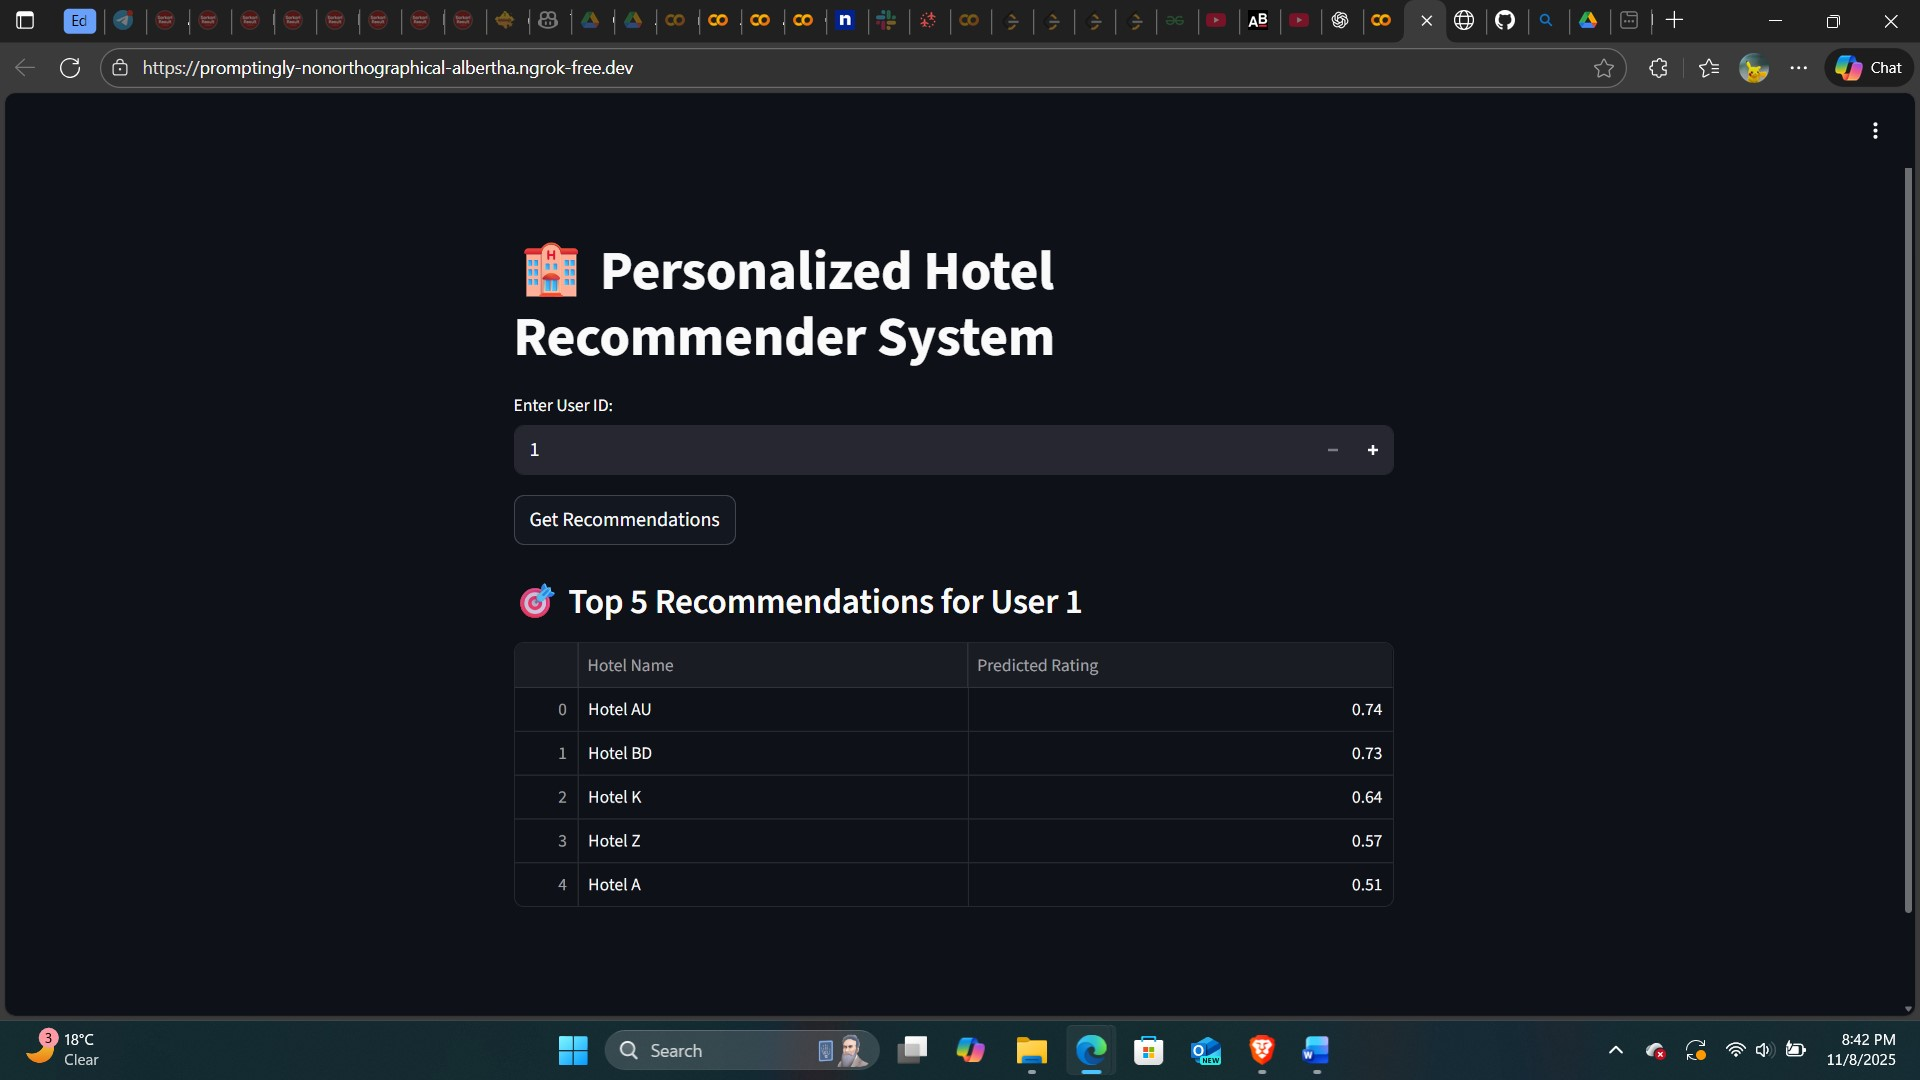

In [7]:
from IPython.display import Image
Image(filename='/content/p1.jpg', width=700)

##Conclusion

The Hotel Recommendation System successfully demonstrates how machine learning can personalize travel experiences by understanding user spending behavior and preference patterns.
By adopting KNN collaborative filtering with MSD similarity, the model provides accurate, user-centric hotel suggestions with minimal error.
Deployed seamlessly via Streamlit and Ngrok, the system offers an interactive, accessible solution that can be extended to include hybrid recommendations, location data, or dynamic pricing analysis.

This project exemplifies the intersection of data analytics, machine learning, and travel personalization, paving the way for smarter, user-aware travel recommendation platforms.